In [82]:
# !pip install psycopg2-binary


# Imports

In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
from datetime import datetime
import plotly.express as px
import unicodedata

import locale
locale.setlocale(locale.LC_TIME, 'pt_BR.UTF-8')

'pt_BR.UTF-8'

In [110]:
pd.set_option('display.max_rows', 100)

# Conexão com o banco de dados postgres

In [111]:
try:
    conn = psycopg2.connect(
        host="localhost",
        database="infracoes_transito",
        user="postgres",
        password="admin"
    )
    print("Conexão ao PostgreSQL estabelecida com sucesso!")
except psycopg2.Error as e:
    print(f"Erro ao conectar ao banco de dados: {e}")

Conexão ao PostgreSQL estabelecida com sucesso!


Criar consulta com o banco

In [112]:
conn.rollback() 
cursor = conn.cursor()
cursor.execute("SELECT * FROM infracoes;")
dados = cursor.fetchall()


Query para contagem de infracoes por ano

In [113]:
query = """
SELECT
    EXTRACT(YEAR FROM 
        CASE
            WHEN datainfracao LIKE '__/__/____' THEN TO_DATE(datainfracao, 'DD/MM/YYYY')
            WHEN datainfracao LIKE '____/__/__' THEN TO_DATE(datainfracao, 'YYYY/MM/DD')
        END
    ) AS ano,
    COUNT(*) AS total
FROM infracoes
WHERE datainfracao IS NOT NULL
GROUP BY ano
ORDER BY ano;
"""
df_ano = pd.read_sql_query(query, conn)
df_ano['ano'] = df_ano['ano'].astype('Int64')
print(df_ano)


/var/folders/d2/by_k15vx3wnc2vtwtptmhy7r0000gn/T/ipykernel_54399/1879104073.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_ano = pd.read_sql_query(query, conn)


    ano   total
0  2018  827540
1  2019  869129
2  2020  706120
3  2021  598556
4  2022  597195
5  2023  488728
6  2024  404975


In [114]:
query = """
SELECT
    EXTRACT(MONTH FROM 
        CASE
            WHEN datainfracao LIKE '__/__/____' THEN TO_DATE(datainfracao, 'DD/MM/YYYY')
            WHEN datainfracao LIKE '____/__/__' THEN TO_DATE(datainfracao, 'YYYY/MM/DD')
        END
    ) AS mes,
    COUNT(*) AS total
FROM infracoes
WHERE datainfracao IS NOT NULL
GROUP BY mes
ORDER BY mes;
"""
df_mes = pd.read_sql_query(query, conn)
df_mes['mes'] = df_mes['mes'].astype('Int64')
print(df_mes)

/var/folders/d2/by_k15vx3wnc2vtwtptmhy7r0000gn/T/ipykernel_54399/4020656450.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_mes = pd.read_sql_query(query, conn)


    mes   total
0     1  423054
1     2  382167
2     3  374994
3     4  332612
4     5  301788
5     6  326353
6     7  371631
7     8  379943
8     9  389544
9    10  407933
10   11  410604
11   12  391620


Criar dataframe

In [115]:
df = pd.DataFrame(dados, columns=[desc[0] for desc in cursor.description])
print(df.head())

  horainfracao                   agenteequipamento infracao  \
0     00:02:07   Cdigo 8 - AUTOS NO TALO ELETRNICO     5550   
1     00:03:51   Cdigo 8 - AUTOS NO TALO ELETRNICO     5550   
2     00:05:00  Cdigo 7 - ZONA AZUL TALO ELETRNICO     5541   
3     00:05:37   Cdigo 8 - AUTOS NO TALO ELETRNICO     5550   
4     00:05:57   Cdigo 8 - AUTOS NO TALO ELETRNICO     6050   

                                   descricaoinfracao           amparolegal  \
0  Estacionar o veculo em locais e horrios proibi...  Art. 181, Inc. XVIII   
1  Estacionar o veculo em locais e horrios proibi...  Art. 181, Inc. XVIII   
2  Estacionar o veculo em desacordo com as condie...   Art. 181, Inc. XVII   
3  Estacionar o veculo em locais e horrios proibi...  Art. 181, Inc. XVIII   
4                Avanar o sinal vermelho do semforo.              Art. 208   

                           localcometimento datainfracao  
0  RUA CARLOS PEREIRA FALCAO SENTIDO UNICO    01/01/2018  
1  RUA CARLOS PEREIRA FALCAO SENTI

# Tratamento de dados

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4492246 entries, 0 to 4492245
Data columns (total 7 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   horainfracao       object
 1   agenteequipamento  object
 2   infracao           object
 3   descricaoinfracao  object
 4   amparolegal        object
 5   localcometimento   object
 6   datainfracao       object
dtypes: object(7)
memory usage: 239.9+ MB


Quantidade de registros e features

In [117]:
df.shape

(4492246, 7)

Verificar valores nulos

In [118]:
df.isnull().sum()

horainfracao          0
agenteequipamento     0
infracao              0
descricaoinfracao     0
amparolegal           3
localcometimento     16
datainfracao          3
dtype: int64

Excluir registros com valores nulos

In [119]:
df = df.dropna()

Registros de infrações (contagem)

In [120]:
registros = len(df)
print(registros)

4492224


In [121]:
tipo_infracoes = len(df['infracao'].unique())
print(tipo_infracoes)

381


In [122]:
datas = len(df['datainfracao'].unique())
print(datas)

2555


Configuração de datas

In [123]:
df['datainfracao'] = pd.to_datetime(df['datainfracao'], errors='coerce', dayfirst=True)

# Agora você pode extrair ano e mês
df['ano'] = df['datainfracao'].dt.year
df['mes'] = df['datainfracao'].dt.month

Configuração de local da infração

In [124]:
df['local_endereco'] = df['localcometimento'].astype(str).str.split(',', n=1).str[0].str.strip()
df

,horainfracao,agenteequipamento,infracao,descricaoinfracao,amparolegal,localcometimento,datainfracao,ano,mes,local_endereco
0,00:02:07,Cdigo 8 - AUTOS NO TALO ELETRNICO,5550,Estacionar o veculo em locais e horrios proibi...,"Art. 181, Inc. XVIII",RUA CARLOS PEREIRA FALCAO SENTIDO UNICO,2018-01-01,2018,1,RUA CARLOS PEREIRA FALCAO SENTIDO UNICO
1,00:03:51,Cdigo 8 - AUTOS NO TALO ELETRNICO,5550,Estacionar o veculo em locais e horrios proibi...,"Art. 181, Inc. XVIII",RUA CARLOS PEREIRA FALCAO SENTIDO UNICO,2018-01-01,2018,1,RUA CARLOS PEREIRA FALCAO SENTIDO UNICO
2,00:05:00,Cdigo 7 - ZONA AZUL TALO ELETRNICO,5541,Estacionar o veculo em desacordo com as condie...,"Art. 181, Inc. XVII",RUA DOS NAVEGANTES,2018-01-01,2018,1,RUA DOS NAVEGANTES
3,00:05:37,Cdigo 8 - AUTOS NO TALO ELETRNICO,5550,Estacionar o veculo em locais e horrios proibi...,"Art. 181, Inc. XVIII",RUA CARLOS PEREIRA FALCAO SENTIDO UNICO,2018-01-01,2018,1,RUA CARLOS PEREIRA FALCAO SENTIDO UNICO
4,00:05:57,Cdigo 8 - AUTOS NO TALO ELETRNICO,6050,Avanar o sinal vermelho do semforo.,Art. 208,RUA BARAO DE SOUZA LEAO,2018-01-01,2018,1,RUA BARAO DE SOUZA LEAO
...,...,...,...,...,...,...,...,...,...,...
4492241,23:38:00,Código 8 - AUTOS NO TALÃO ELETRÔNICO,7684,"Conduzir motocicleta, motoneta ou ciclomotor c...","Art. 244, X",AVENIDA HERCULANO BANDEIRA,2024-12-31,2024,12,AVENIDA HERCULANO BANDEIRA
4492242,23:43:00,Código 8 - AUTOS NO TALÃO ELETRÔNICO,7340,Dirigir o veículo usando calçado que não se fi...,"Art. 252, Inc. IV",RUA PEREIRA DA COSTA,2024-12-31,2024,12,RUA PEREIRA DA COSTA
4492243,23:48:00,Código 8 - AUTOS NO TALÃO ELETRÔNICO,6483,Usar buzina em situação que não a de simples t...,"Art. 227, Inc. I",AVENIDA BOA VIAGEM,2024-12-31,2024,12,AVENIDA BOA VIAGEM
4492244,23:54:00,Código 8 - AUTOS NO TALÃO ELETRÔNICO,6483,Usar buzina em situação que não a de simples t...,"Art. 227, Inc. I",AVENIDA BOA VIAGEM,2024-12-31,2024,12,AVENIDA BOA VIAGEM


Cálculos para KPIs

In [125]:
# Contagem por ano e mês
contar_ano_mes = df.groupby(['ano', 'mes']).size().reset_index(name='quantidade')
contar_ano_mes

,ano,mes,quantidade
0,2018,1,65869
1,2018,2,68925
2,2018,3,62221
3,2018,4,59192
4,2018,5,36347
5,2018,6,54384
6,2018,7,68852
7,2018,8,78608
8,2018,9,85470
9,2018,10,85135


In [161]:
# Contagem por ano
contar_ano = df.groupby(['ano']).size().reset_index(name='quantidade')
contar_ano

,ano,quantidade
0,2018,827538
1,2019,869124
2,2020,706108
3,2021,598556
4,2022,597195
5,2023,488728
6,2024,404975


In [169]:
# Contagem por mes
contar_mes = df.groupby(['mes']).size().reset_index(name='quantidade')
contar_mes

,mes,quantidade
0,1,423054
1,2,382163
2,3,374993
3,4,332612
4,5,301788
5,6,326353
6,7,371629
7,8,379938
8,9,389541
9,10,407933


In [127]:
# Contagem por infração
contar_por_infracao = df['infracao'].value_counts()
contar_por_infracao

infracao
7455      1308549
5541       516877
5550       370545
7633       332614
6050       286323
           ...   
6475,0          1
5126,0          1
7110,0          1
6920,0          1
7749            1
Name: count, Length: 381, dtype: int64

In [144]:
substituicoes = {
    'AVENIDA': 'AV',
    'CONDE': 'CDE',
    'GOVERNADOR': 'GOV',
    'DOUTOR': 'DR',
    'MARECHAL': 'MAL',
    'CAXANG' : 'CAXANGA',
    'CAXANGAAA' : 'CAXANGA',
    'CAXANGAA' : 'CAXANGA',
    'VISCDE' : 'VISCONDE',
    'VISC' : 'VISCONDE',
    'ARQUITETO' : 'ARQ',
    'RUA ARQ LUIZ NUNES CRUZAMENTO RUA DEOLINDO TAVARES ' : 'RUA ARQUITETO LUIZ NUNES'
}

df['local_endereco'] = (
    df['local_endereco']
    .str.upper()
    .replace(substituicoes, regex=True)
)


In [142]:
df['local_endereco'] = df['local_endereco'].str.rstrip()

In [177]:
df['agenteequipamento'].unique()

array(['Cdigo 8 - AUTOS NO TALO ELETRNICO',
       'Cdigo 7 - ZONA AZUL TALO ELETRNICO',
       'Cdigo 3 - LOMBADA ELETRNICA', 'Cdigo 5 - FOTO SENSOR',
       'Cdigo 9 - FAIXA AZUL', 'Cdigo 6 - AUTOS NO TALO MANUAL',
       'Cdigo 4 - RADAR', 'Código 4 - RADAR',
       'Código 8 - AUTOS NO TALÃO ELETRÔNICO', 'Código 5 - FOTO SENSOR',
       'Código 3 - LOMBADA ELETRÔNICA',
       'Código 7 - ZONA AZUL TALÃO ELETRÔNICO',
       'Código 5 - FOTO SENSOR,0', 'Código 3 - LOMBADA ELETRÔNICA,0',
       'Código 8 - AUTOS NO TALÃO ELETRÔNICO,0',
       'Código 7 - ZONA AZUL TALÃO ELETRÔNICO,0', 'Código 4 - RADAR,0',
       'Código 8 - AUTOS NO TALÃO ELETRÔNICO ',
       'Código 3 - LOMBADA ELETRÔNICA        ',
       'Código 5 - FOTO SENSOR               ',
       'Código 4 - RADAR                     ',
       'Código 9 - FAIXA AZUL                ', 'Código 9 - FAIXA AZUL'],
      dtype=object)

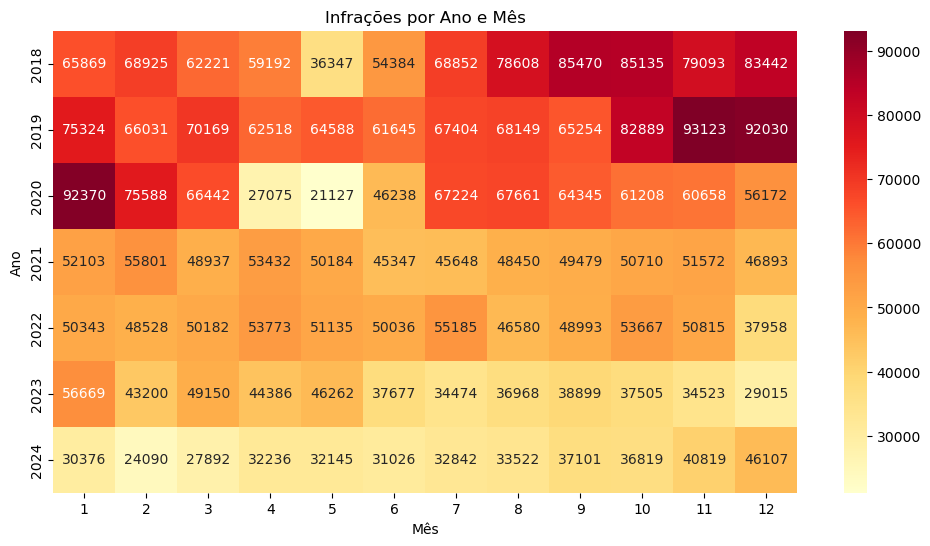

In [148]:
heatmap_data = df.pivot_table(
    index='ano',
    columns='mes',
    values='infracao',
    aggfunc='count',
    fill_value=0
)

plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Infrações por Ano e Mês')
plt.xlabel('Mês')
plt.ylabel('Ano')
plt.show()


In [154]:
infracoes_por_tipo = df['descricaoinfracao'].value_counts().nlargest(10).reset_index()
infracoes_por_tipo.columns = ['infracao', 'quantidade']

In [156]:
infracoes_por_local = df['local_endereco'].value_counts().nlargest(10).reset_index()
infracoes_por_local.columns = ['infracao', 'quantidade']

In [157]:
fig = px.bar_polar(
    infracoes_por_local,
    r="quantidade",
    theta="infracao",
    color="quantidade",
    template="plotly_dark",
    color_discrete_sequence=px.colors.sequential.Plasma_r
)

fig.update_layout(title="Distribuição de Infrações por Localidade")
fig.show()


In [172]:
fig = px.line(
    contar_ano,
    x='ano',
    y='quantidade',
    title='Evolução Anual das Infrações de Trânsito',
    markers=True,
    template='plotly_dark'
)
fig.show()

In [173]:
contar_ano['media_movel'] = contar_ano['quantidade'].rolling(window=3).mean()

fig.add_scatter(
    x=contar_ano['ano'],
    y=contar_ano['media_movel'],
    mode='lines',
    name='Média Móvel (3 anos)',
    line=dict(dash='dash', width=3, color='orange')
)

fig.update_layout(
    xaxis_title='Ano',
    yaxis_title='Quantidade de Infrações',
    legend_title='Indicadores'
)

fig.show()

In [195]:
# === Padronização dos nomes dos agentes ===
agente_equip = {
    'Cdigo 8 - AUTOS NO TALO ELETRNICO': 'AUTOS NO TALO ELETRONICO',
    'Cdigo 7 - ZONA AZUL TALO ELETRNICO': 'ZONA AZUL TALAO ELETRONICO',
    'Cdigo 3 - LOMBADA ELETRNICA': 'LOMBADA ELETRONICA',
    'Cdigo 5 - FOTO SENSOR': 'FOTO SENSOR',
    'Cdigo 9 - FAIXA AZUL': 'FAIXA AZUL',
    'Cdigo 6 - AUTOS NO TALO MANUAL': 'AUTOS NO TALO MANUAL',
    'Cdigo 4 - RADAR': 'RADAR',
    'Código 4 - RADAR': 'RADAR',
    'Código 8 - AUTOS NO TALÃO ELETRÔNICO': 'AUTOS NO TALAO ELETRONICO',
    'Código 5 - FOTO SENSOR': 'FOTO SENSOR',
    'Código 3 - LOMBADA ELETRÔNICA,0': 'LOMBADA ELETRONICA',
    'Código 8 - AUTOS NO TALÃO ELETRÔNICO,0': 'AUTOS NO TALAO ELETRONICO',
    'Código 7 - ZONA AZUL TALÃO ELETRÔNICO,0': 'ZONA AZUL TALAO ELETRONICO',
    'Código 4 - RADAR,0': 'RADAR',
    'Código 8 - AUTOS NO TALÃO ELETRÔNICO ': 'AUTOS NO TALAO ELETRONICO',
    'Código 3 - LOMBADA ELETRÔNICA        ': 'LOMBADA ELETRONICA',
    'Código 5 - FOTO SENSOR               ': 'FOTO SENSOR',
    'Código 4 - RADAR                     ': 'RADAR',
    'Código 9 - FAIXA AZUL                ': 'FAIXA AZUL',
    'Código 9 - FAIXA AZUL': 'FAIXA AZUL'
}

# === Normaliza os textos ===
df['agenteequipamento'] = (
    df['agenteequipamento']
    .astype(str)
    .str.strip()
    .replace(agente_equip)
)

# === Cria o DataFrame de contagem ===
contagem_agente = (
    df['agenteequipamento']
    .value_counts()
    .reset_index()
)

# === Corrige nome das colunas manualmente (sem erro) ===
contagem_agente.columns = ['agenteequipamento', 'quantidade']

print(contagem_agente.head())
print("Colunas:", contagem_agente.columns)

# === Gera o gráfico Treemap ===
fig = px.treemap(
    contagem_agente,
    path=[px.Constant('Infrações de Trânsito'), 'agenteequipamento'],
    values='quantidade',
    color='quantidade',
    color_continuous_scale='Plasma',
    title='Distribuição de Infrações por Agente/Equipamento'
)

fig.update_layout(
    template='plotly_dark',
    margin=dict(t=60, l=25, r=25, b=25)
)

fig.show()


                   agenteequipamento  quantidade
0  CDIGO 8 - AUTOS NO TALO ELETRNICO     1151320
1        CDIGO 3 - LOMBADA ELETRNICA      855051
2                 LOMBADA ELETRONICA      608053
3          AUTOS NO TALAO ELETRONICO      607105
4         ZONA AZUL TALAO ELETRONICO      282609
Colunas: Index(['agenteequipamento', 'quantidade'], dtype='object')


In [196]:
# Agrupar e contar as infrações por descrição
contagem_descr = (
    df['descricaoinfracao']
    .astype(str)
    .str.strip()
    .value_counts()
    .reset_index()
)

# Renomear colunas
contagem_descr.columns = ['descricaoinfracao', 'quantidade']

# Manter apenas as 20 mais comuns (opcional)
contagem_descr = contagem_descr.head(20)

# Criar gráfico de barras horizontais
fig = px.bar(
    contagem_descr,
    x='quantidade',
    y='descricaoinfracao',
    orientation='h',
    color='quantidade',
    color_continuous_scale='Plasma',
    title='Top 20 Infrações de Trânsito Mais Comuns',
)

# Layout visual
fig.update_layout(
    template='plotly_dark',
    yaxis=dict(title='', automargin=True),
    xaxis_title='Quantidade de Infrações',
    margin=dict(t=60, l=150, r=40, b=40)
)

fig.show()